# Explore here

In [130]:
#!pip install hdbscan

  Using cached hdbscan-0.8.38.post1.tar.gz (5.8 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build hdbscan


  error: subprocess-exited-with-error
  
  × Building wheel for hdbscan (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [34 lines of output]
      C:\Program Files\KMSpico\temp\pip-build-env-o5r2ik__\overlay\Lib\site-packages\setuptools\_distutils\dist.py:268: UserWarning: Unknown distribution option: 'test_suite'
        warnings.warn(msg)
      C:\Program Files\KMSpico\temp\pip-build-env-o5r2ik__\overlay\Lib\site-packages\setuptools\_distutils\dist.py:268: UserWarning: Unknown distribution option: 'tests_require'
        warnings.warn(msg)
      C:\Program Files\KMSpico\temp\pip-build-env-o5r2ik__\overlay\Lib\site-packages\setuptools\dist.py:289: InformationOnly: Normalizing '0.8.38-1' to '0.8.38.post1'
        self.metadata.version = self._normalize_version(self.metadata.version)
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-312
      creating build\lib.win-amd64-cpython-312\hdbs

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import BaggingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import joblib
import requests
from sklearn.linear_model import LinearRegression
  

In [96]:

url = 'https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv'
response = requests.get(url, 'html.parser')

with open('C:/Users/Agustín/Desktop/4Geeks/Clases/14. EDA Machine Learning Algo/machine-learning-python-template/data/raw/datahtml.csv', mode='wb') as file:
    file.write(response.content)

In [97]:
df = pd.read_csv('C:/Users/Agustín/Desktop/4Geeks/Clases/14. EDA Machine Learning Algo/machine-learning-python-template/data/raw/datahtml.csv').iloc[:,1:]
pd.set_option('display.max_columns', None)
df.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.65,-73.97,Private room,149,1,9,2018-10-19,0.21,6,365
1,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,NaN,1,365
3,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [98]:
df.tail()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
48890,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.68,-73.95,Private room,70,2,0,NaN,NaN,2,9
48891,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70,-73.93,Private room,40,4,0,NaN,NaN,2,36
48892,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81,-73.95,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.76,-73.99,Shared room,55,1,0,NaN,NaN,6,2
48894,Trendy duplex in the very heart of Hell's Kitchen,68119814,Christophe,Manhattan,Hell's Kitchen,40.76,-73.99,Private room,90,7,0,NaN,NaN,1,23


In [99]:
print(df.shape)
df.info()

(48895, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            48879 non-null  object 
 1   host_id                         48895 non-null  int64  
 2   host_name                       48874 non-null  object 
 3   neighbourhood_group             48895 non-null  object 
 4   neighbourhood                   48895 non-null  object 
 5   latitude                        48895 non-null  float64
 6   longitude                       48895 non-null  float64
 7   room_type                       48895 non-null  object 
 8   price                           48895 non-null  int64  
 9   minimum_nights                  48895 non-null  int64  
 10  number_of_reviews               48895 non-null  int64  
 11  last_review                     38843 non-null  object 
 12  reviews_per_month   

In [100]:
unique_var = df.nunique()==1

if any(unique_var): 
    for col in unique_var.index[unique_var] : print(f"The variable {i} content only one category.")
else: print(f"There's no variable with only one category.")

There's no variable with only one category.


In [101]:
print(f'Number of duplicated values: {df.duplicated().sum()}') 
#df.drop("PassengerId", axis = 1).duplicated().sum() si tuvieramos que sacar alguna columna del analisis de los duplicados usamos el drop definiendo qué columnas
# tambien eliminaríamos los duplicados con "drop_duplicates()"

Number of duplicated values: 0


In [102]:
df_lastreviews = df['last_review'].dropna() # no sé porque no me elimina todos los 'Nan'
print(df['last_review'].head())

0    2018-10-19
1    2019-05-21
2           NaN
3    2019-07-05
4    2018-11-19
Name: last_review, dtype: object


The column "last_review" is a date type value, and we don't really know yet if we're gonna use it or not... \
we keep that variable included in the df by the moment, and further we'll decide wheter it suits for determine \
if it correlates with another variable

In [103]:
df.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.65,-73.97,Private room,149,1,9,2018-10-19,0.21,6,365
1,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,NaN,1,365
3,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [104]:
df.drop(columns=['name','host_id','host_name'],inplace=True) #variables que no me sirven
df.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,48895.00,40.73,0.05,40.50,40.69,40.72,40.76,40.91
longitude,48895.00,-73.95,0.05,-74.24,-73.98,-73.96,-73.94,-73.71
price,48895.00,152.72,240.15,0.00,69.00,106.00,175.00,10000.00
minimum_nights,48895.00,7.03,20.51,1.00,1.00,3.00,5.00,1250.00
number_of_reviews,48895.00,23.27,44.55,0.00,1.00,5.00,24.00,629.00
reviews_per_month,38843.00,1.37,1.68,0.01,0.19,0.72,2.02,58.50
calculated_host_listings_count,48895.00,7.14,32.95,1.00,1.00,1.00,2.00,327.00
availability_365,48895.00,112.78,131.62,0.00,0.00,45.00,227.00,365.00


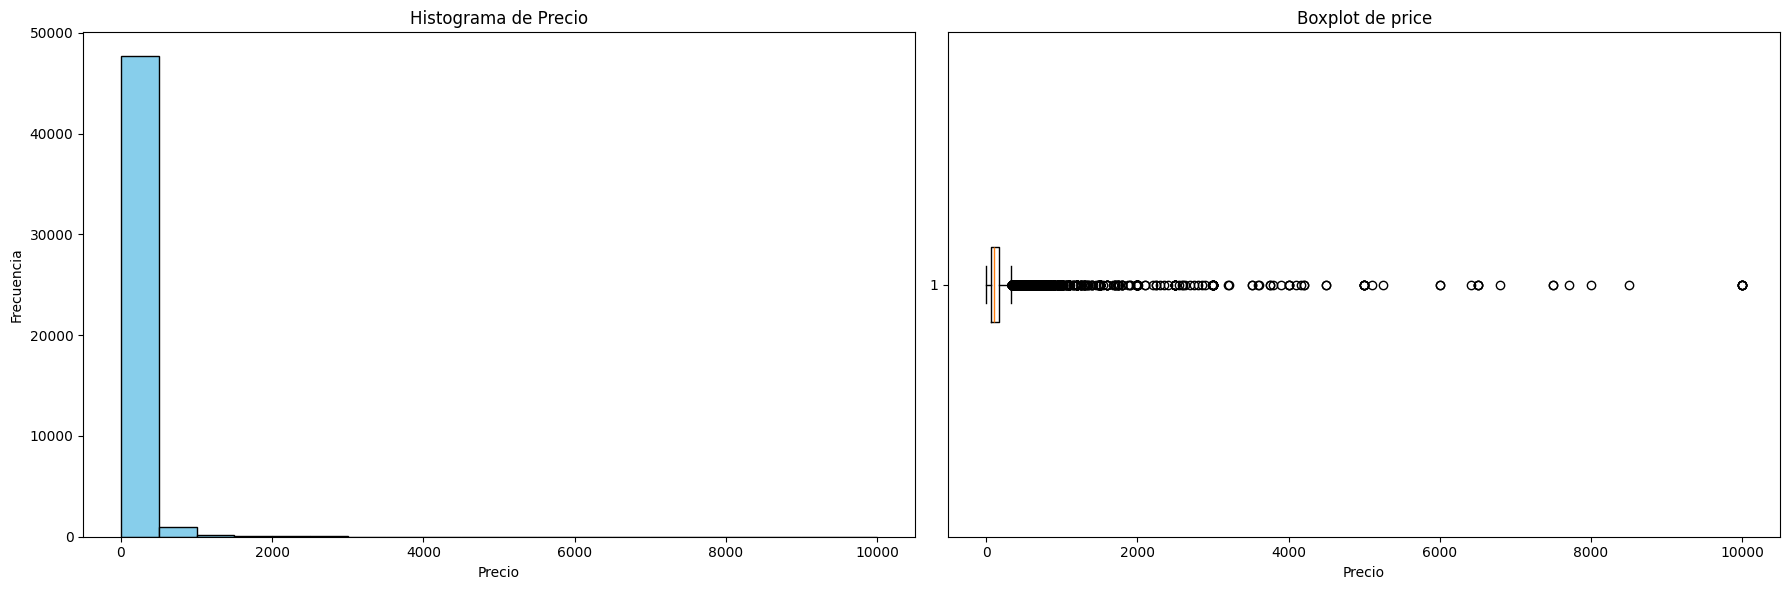

In [105]:
# Crear una figura con dos subplots (uno para el histograma y otro para el boxplot)
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Crear un histograma en el primer subplot
ax[0].hist(df['price'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_title('Histograma de Precio')
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencia')

# Crear un boxplot en el segundo subplot
ax[1].boxplot(df['price'], vert=False)
ax[1].set_title('Boxplot de price')
ax[1].set_xlabel('Precio')

# Mostrar la figura
plt.tight_layout()
plt.show()

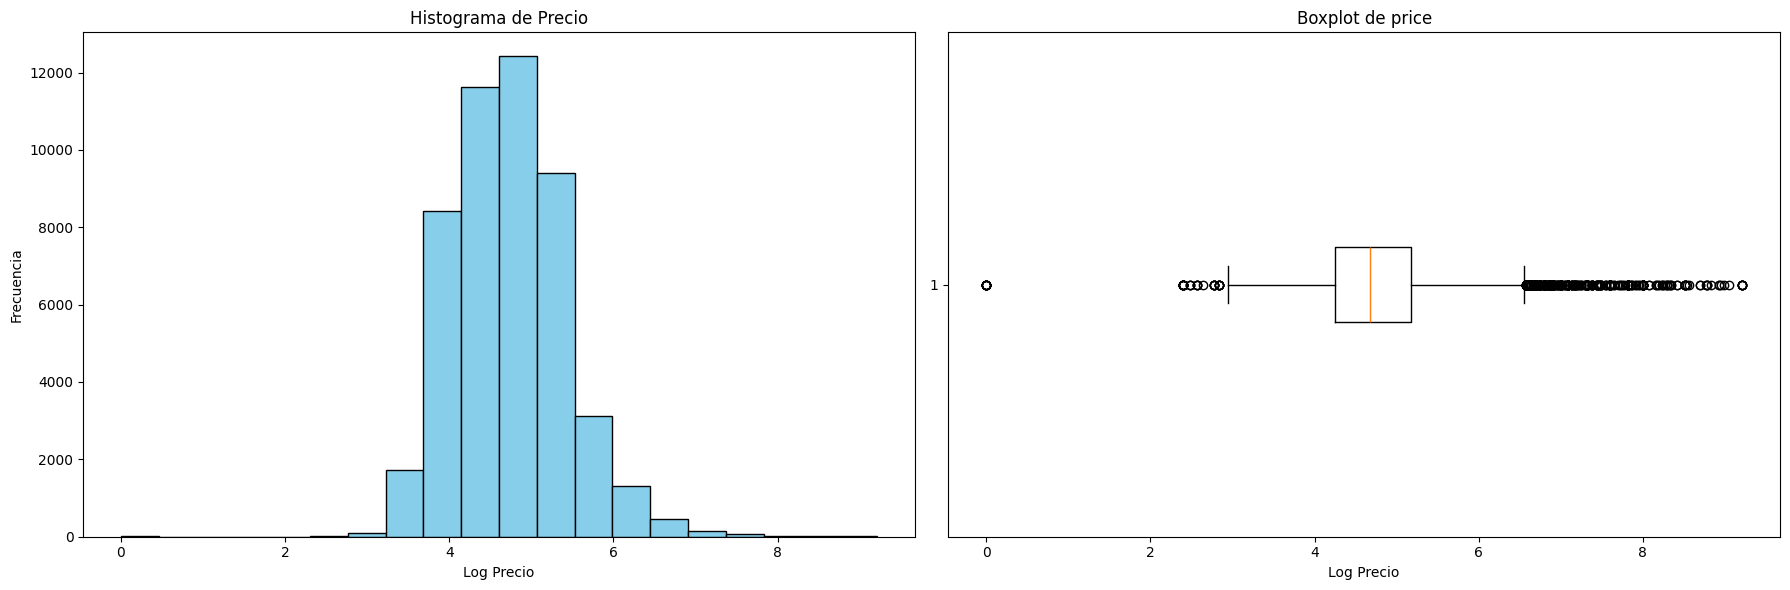

In [106]:
df['Log_Price'] = np.log(df.price+1)
# Crear una figura con dos subplots (uno para el histograma y otro para el boxplot)
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Crear un histograma en el primer subplot
ax[0].hist(df['Log_Price'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_title('Histograma de Precio')
ax[0].set_xlabel('Log Precio')
ax[0].set_ylabel('Frecuencia')

# Crear un boxplot en el segundo subplot
ax[1].boxplot(df['Log_Price'], vert=False)
ax[1].set_title('Boxplot de price')
ax[1].set_xlabel('Log Precio')

# Mostrar la figura
plt.tight_layout()
plt.show()



In [107]:
print(df.isnull().sum())
df.isnull().mean()*100

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
Log_Price                             0
dtype: int64


neighbourhood_group               0.00
neighbourhood                     0.00
latitude                          0.00
longitude                         0.00
room_type                         0.00
price                             0.00
minimum_nights                    0.00
number_of_reviews                 0.00
last_review                      20.56
reviews_per_month                20.56
calculated_host_listings_count    0.00
availability_365                  0.00
Log_Price                         0.00
dtype: float64

In [108]:
asd = df.isnull().any(axis=1).sum()/len(df)*100
print(f'The {asd:.2f}% of rows have at least one null value')

The 20.56% of rows have at least one null value


<Axes: >

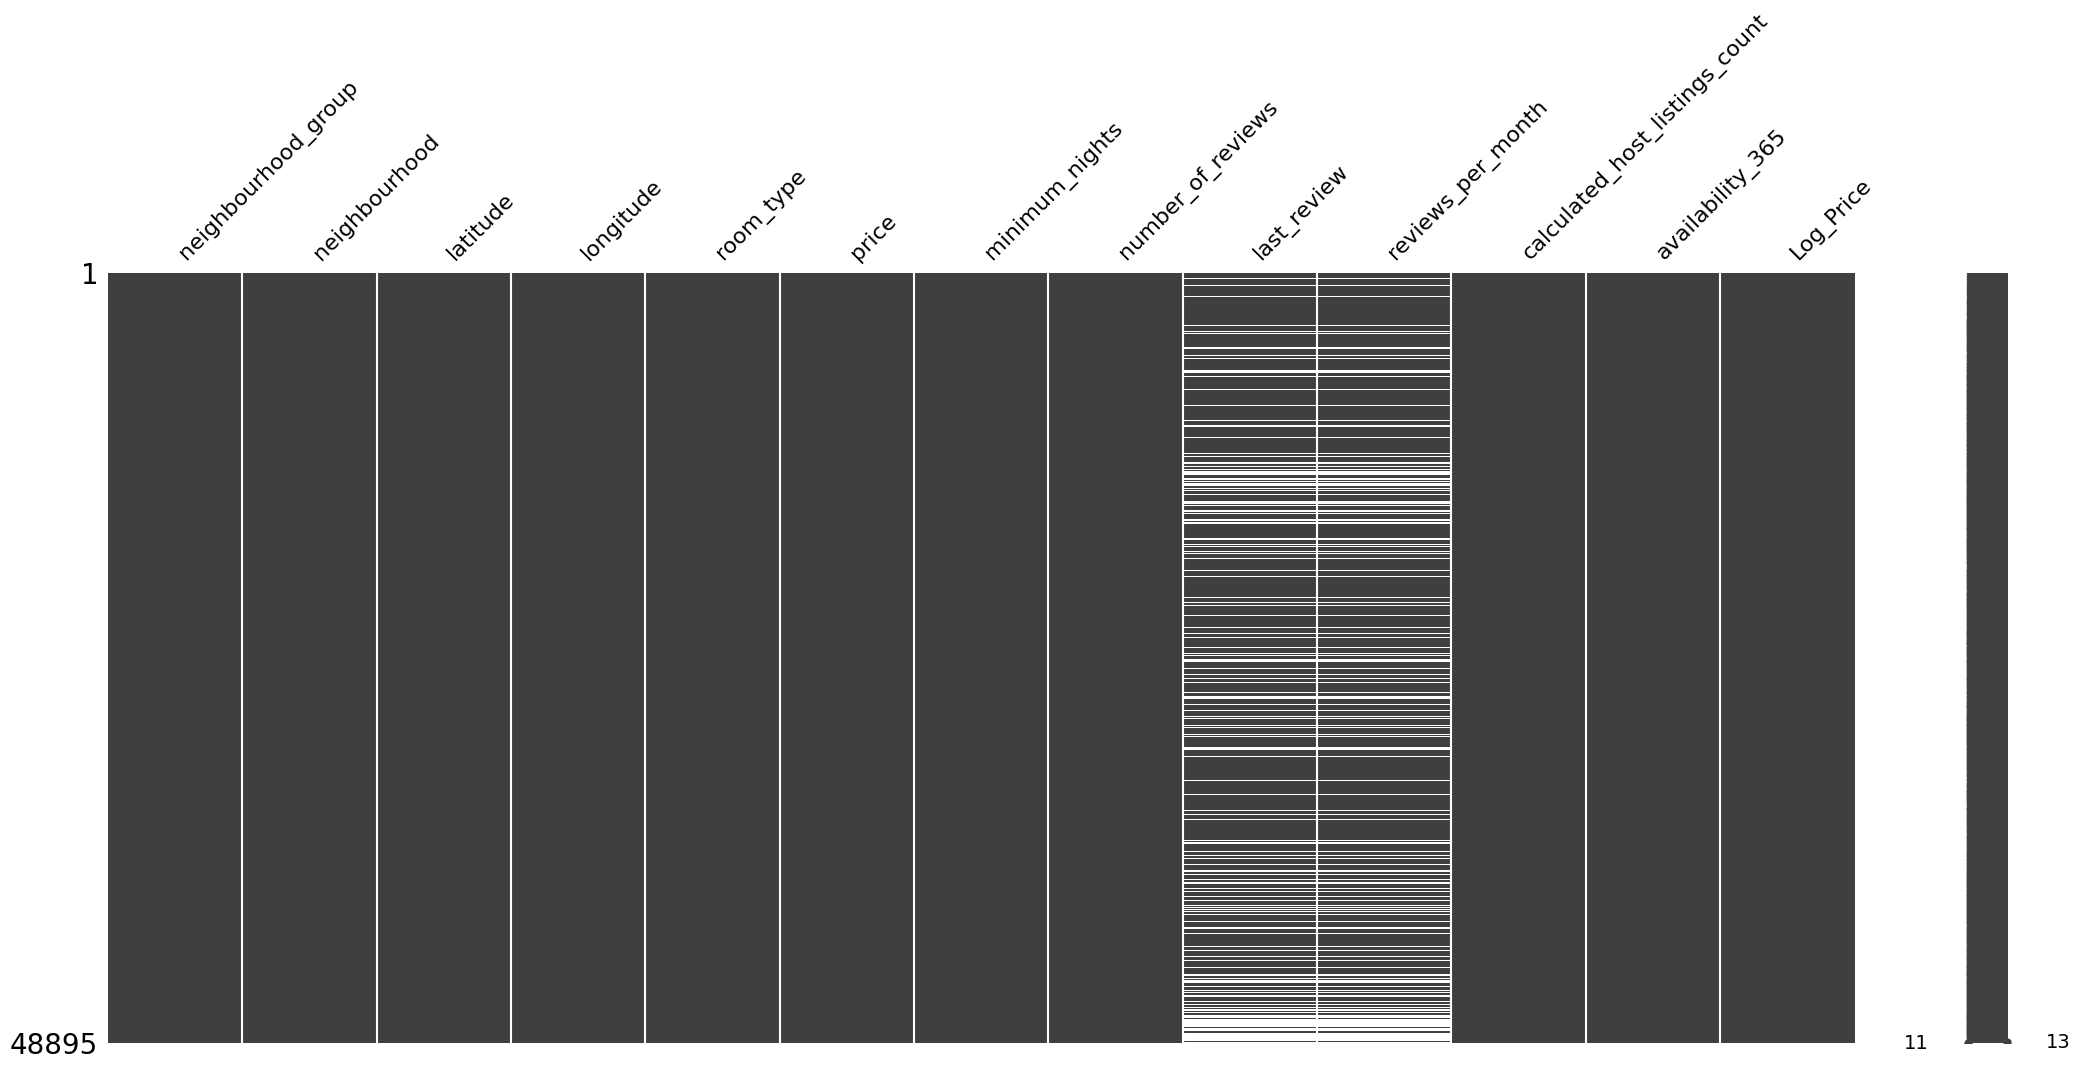

In [109]:
msno.matrix(df) # nos da un "mapa" donde podemos visualizar los valores null o faltantes del dataframe de manera visual

In [110]:
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,Log_Price
0,Brooklyn,Kensington,40.65,-73.97,Private room,149,1,9,2018-10-19,0.21,6,365,5.01
1,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,5.42
2,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,NaN,1,365,5.02
3,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,4.50
4,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,4.39


In [111]:
imputador_knn = KNNImputer(n_neighbors=5) #busca los "vecinos" más cercanos (en este caso, filas similares) para estimar los valores faltantes
#df[['last_review', 'reviews_per_month']] = imputador_knn.fit_transform(df[['last_review', 'reviews_per_month']])
imputador_knn

KNNImputer()

I don't think is convenient to fill the missing values in 'last_review' & 'reviews_per_month' because we might corrupt data \
probably needed for further analysis

In [112]:
df.dtypes

neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
Log_Price                         float64
dtype: object

In [113]:
#para ver cuantas variables dummies deberiamos incluir en el dataframe
print(f'Number of neighbourhood_group variables: {df.neighbourhood_group.nunique()}') 
print(f'Number of neighbourhood variables: {df.neighbourhood.nunique()}')
print(f'Number of room_type variables: {df.room_type.nunique()}')

Number of neighbourhood_group variables: 5
Number of neighbourhood variables: 221
Number of room_type variables: 3


Due to the amout of categories in both variables, we can conclude that is unconvenient to set dummies variables \
for "neighbourhood" categories, but we'll do it for "neighbourhood_group" and "room_type".

In [114]:
df_with_dummies = pd.get_dummies(df, columns=['neighbourhood_group','room_type'],drop_first=False) # creamos las dummies de 'neighbourhood_group' y 'room_type'
#df_with_dummies = df_with_dummies.astype(int) 
df_with_dummies.head()

,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,Log_Price,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,Kensington,40.65,-73.97,149,1,9,2018-10-19,0.21,6,365,5.01,False,True,False,False,False,False,True,False
1,Midtown,40.75,-73.98,225,1,45,2019-05-21,0.38,2,355,5.42,False,False,True,False,False,True,False,False
2,Harlem,40.81,-73.94,150,3,0,NaN,NaN,1,365,5.02,False,False,True,False,False,False,True,False
3,Clinton Hill,40.69,-73.96,89,1,270,2019-07-05,4.64,1,194,4.50,False,True,False,False,False,True,False,False
4,East Harlem,40.80,-73.94,80,10,9,2018-11-19,0.10,1,0,4.39,False,False,True,False,False,True,False,False


In [115]:
#reemplazo cada categ de 'neighbourhood' por su frecuencia de ocurrencia dentro de la lista
freq = df_with_dummies['neighbourhood'].value_counts()
df_with_dummies['neighbourhood_encoded'] = df_with_dummies['neighbourhood'].map(freq)
df_with_dummies.head()

,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,Log_Price,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_encoded
0,Kensington,40.65,-73.97,149,1,9,2018-10-19,0.21,6,365,5.01,False,True,False,False,False,False,True,False,175
1,Midtown,40.75,-73.98,225,1,45,2019-05-21,0.38,2,355,5.42,False,False,True,False,False,True,False,False,1545
2,Harlem,40.81,-73.94,150,3,0,NaN,NaN,1,365,5.02,False,False,True,False,False,False,True,False,2658
3,Clinton Hill,40.69,-73.96,89,1,270,2019-07-05,4.64,1,194,4.50,False,True,False,False,False,True,False,False,572
4,East Harlem,40.80,-73.94,80,10,9,2018-11-19,0.10,1,0,4.39,False,False,True,False,False,True,False,False,1117


In [116]:
X = df_with_dummies.drop(['Log_Price','neighbourhood','last_review','reviews_per_month'], axis=1)
X = X.astype(int) # tuve que hacer esto porque los bool no los toma como 0 y 1
y = df_with_dummies.Log_Price


# Ajusta el modelo
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Instancia de la influencia y obtención de la distancia de cook para cada observación
cooks_distance = model.get_influence().cooks_distance

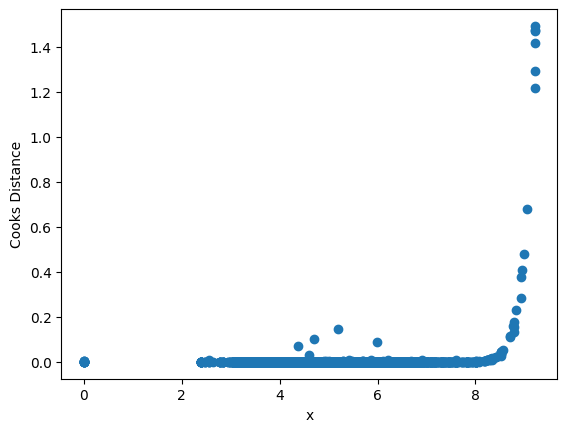

In [117]:
plt.scatter(df_with_dummies.Log_Price, cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

In [118]:
#quiero ver cuales son y si encuentro un patron por demas obvio
influent_rows = np.where(cooks_distance[0]>0.4) 
df_with_dummies.iloc[influent_rows]

,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,Log_Price,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_encoded
4377,Clinton Hill,40.69,-73.97,8000,1,1,2016-09-15,0.03,11,365,8.99,False,True,False,False,False,True,False,False,572
6530,East Harlem,40.79,-73.94,9999,5,1,2015-01-02,0.02,1,0,9.21,False,False,True,False,False,True,False,False,1117
9151,Astoria,40.77,-73.92,10000,100,2,2016-02-13,0.04,1,0,9.21,False,False,False,True,False,False,True,False,900
12342,Lower East Side,40.71,-73.99,9999,99,6,2016-01-01,0.14,1,83,9.21,False,False,True,False,False,False,True,False,911
17692,Greenpoint,40.73,-73.96,10000,5,5,2017-07-27,0.16,1,0,9.21,False,True,False,False,False,True,False,False,1115
29238,Upper West Side,40.77,-73.99,10000,30,0,NaN,NaN,1,83,9.21,False,False,True,False,False,True,False,False,1971
29662,Upper East Side,40.77,-73.96,7703,1,0,NaN,NaN,12,146,8.95,False,False,True,False,False,True,False,False,1798
30268,Tribeca,40.72,-74.01,8500,30,2,2018-09-18,0.18,1,251,9.05,False,False,True,False,False,True,False,False,177
40433,Lower East Side,40.72,-73.99,9999,30,0,NaN,NaN,1,365,9.21,False,False,True,False,False,True,False,False,911


In [133]:
df_with_dummies.iloc[influent_rows].T

,4377,6530,9151,12342,17692,29238,29662,30268,40433
neighbourhood,Clinton Hill,East Harlem,Astoria,Lower East Side,Greenpoint,Upper West Side,Upper East Side,Tribeca,Lower East Side
latitude,40.69,40.79,40.77,40.71,40.73,40.77,40.77,40.72,40.72
longitude,-73.97,-73.94,-73.92,-73.99,-73.96,-73.99,-73.96,-74.01,-73.99
price,8000,9999,10000,9999,10000,10000,7703,8500,9999
minimum_nights,1,5,100,99,5,30,1,30,30
number_of_reviews,1,1,2,6,5,0,0,2,0
last_review,2016-09-15,2015-01-02,2016-02-13,2016-01-01,2017-07-27,NaN,NaN,2018-09-18,NaN
reviews_per_month,0.03,0.02,0.04,0.14,0.16,NaN,NaN,0.18,NaN
calculated_host_listings_count,11,1,1,1,1,1,12,1,1
availability_365,365,0,0,83,0,83,146,251,365


Don't know if we should drop this influent rows or not... We'll keep then by the moment

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [136]:
# Si la distancia es mayor de 4/n se considera observación influyente
pto_corte = 4/len(X)
pto_corte

8.180795582370386e-05

In [137]:
# Viviendas que se consideran observaciones influyentes
len(np.where(cooks_distance[0]>pto_corte)[0])/len(X)*100

3.2007362716024135

In [139]:
df_with_dummies.drop(np.where(cooks_distance[0]>pto_corte)[0], inplace=True)
df_with_dummies.shape

(47330, 20)

In [140]:
X = df_with_dummies.drop(['Log_Price'], axis=1)
y = df_with_dummies.Log_Price

Vamos a seleccionar aleatoriamente un 80% del dataset para formar el conjunto de entrenamiento y un 20% para el conjunto de test.

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_encoded
44760,Upper East Side,40.77,-73.96,350,4,4,2019-06-15,2.67,1,143,False,False,True,False,False,False,True,False,1798
20491,Bushwick,40.70,-73.92,30,3,2,2017-01-11,0.07,1,0,False,True,False,False,False,False,True,False,2465
3742,Williamsburg,40.72,-73.96,85,14,1,2014-08-20,0.02,1,0,False,True,False,False,False,False,True,False,3920
29857,Woodhaven,40.70,-73.85,50,4,1,2018-03-03,0.06,1,0,False,False,False,True,False,True,False,False,88
28972,Bedford-Stuyvesant,40.68,-73.95,38,4,5,2018-06-11,0.27,1,0,False,True,False,False,False,True,False,False,3714


In [142]:
# Usamos xgb para conocer la importancia de las características
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_train, y_train)
df_imp = pd.DataFrame({'Feature':X_train.columns, 'Importance':xgb_model.feature_importances_*100})
df_imp = df_imp.sort_values(by='Importance', ascending=False)
df_imp

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:neighbourhood: object, last_review: object